## Get data from bucket

In [2]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

### Train Model

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import boto3
import os

2024-07-21 04:28:10.391482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 04:28:10.540568: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-07-21 04:28:10.541147: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-07-21 04:28:10.541345: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-2

In [4]:
print(tf.__version__)

2.11.0


In [5]:
# Set the S3 bucket paths
bucket_name = ##redacted
s3_directory_key = 'avi_vs_noAvi_resized_balanced_train_val_test_split'

In [6]:
# Local directory to save images
local_directory = 'local_image_directory_binary'

# Create the local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)


In [7]:
# Local Directory paths
local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')

In [17]:
#### DO NOT RUN if don't want to create a local copy of dataset
RUN_THIS = False

s3 = boto3.client('s3')

# List all objects in the S3 directory
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=s3_directory_key)
        
if RUN_THIS:
    # Download each image and recreate the folder structure
    for page in pages:
        for obj in page['Contents']:
            key = obj['Key']
            if key.endswith('/'):  # Skip directories
                continue
            # Recreate the directory structure locally
            relative_path = os.path.relpath(key, s3_directory_key)
            local_file_path = os.path.join(local_directory, relative_path)
            local_file_dir = os.path.dirname(local_file_path)
            if not os.path.exists(local_file_dir):
                os.makedirs(local_file_dir)
            # Download the file
            s3.download_file(bucket_name, key, local_file_path)

else:
    print("Skipped downloading images from s3")

Skipped downloading images from s3


In [8]:
# Function to load datasets
def load_datasets(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    train_dataset = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True
    )
    
    val_dataset = image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    test_dataset = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    return train_dataset, val_dataset, test_dataset

In [9]:
# Load datasets
train_dataset, val_dataset, test_dataset = load_datasets(local_train, local_val, local_test)

Found 1368 files belonging to 2 classes.


2024-07-21 04:28:34.860418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 04:28:34.869177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 04:28:34.870997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 04:28:34.873362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

Found 344 files belonging to 2 classes.
Found 430 files belonging to 2 classes.


In [10]:
# Function to build the model
def build_model():
    base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model


In [11]:
# Build the model
model = build_model()

# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/avi_noAvi_best_model_3',  # specify the directory to save the model
    monitor='val_accuracy',                        # monitor validation accuracy
    save_best_only=True,                           # save only the best model
    mode='max',                                    # mode is 'max' for accuracy
    save_weights_only=False,                       # set to False to save the entire model
    verbose=1                                      # verbosity mode, 1 for progress bar
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


2024-07-21 04:29:01.007084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-21 04:29:04.707028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2024-07-21 04:29:09.013599: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f85528d5ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-21 04:29:09.013642: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-21 04:29:09.018295: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 04:29:09.162671: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled clust

43/43 [==============================] - 32s 292ms/step - loss: 0.5808 - accuracy: 0.7390 - val_loss: 0.5203 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 7s 151ms/step - loss: 0.4884 - accuracy: 0.7756 - val_loss: 0.4639 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 7s 152ms/step - loss: 0.4509 - accuracy: 0.8048 - val_loss: 0.4339 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - 7s 152ms/step - loss: 0.4230 - accuracy: 0.8187 - val_loss: 0.4113 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 7s 152ms/step - loss: 0.3892 - accuracy: 0.8421 - val_loss: 0.3953 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 6/20
43/43 [==============================] - 7s 152ms/step - loss: 0.3830 - accuracy: 0.8377 - val_loss: 0.3838 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
43/43 [==============================] - 7s 152ms/step - loss: 0.3688

In [12]:
model.save('models/avi_noAvi_best_model_3')

INFO:tensorflow:Assets written to: models/avi_noAvi_best_model_3/assets


INFO:tensorflow:Assets written to: models/avi_noAvi_best_model_3/assets


In [13]:
print(model)

## Analyze Results

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

In [15]:
## Load Best Model
best_model = tf.keras.models.load_model('models/avi_noAvi_best_model_3')

1/1 [==============================] - 4s 4s/step


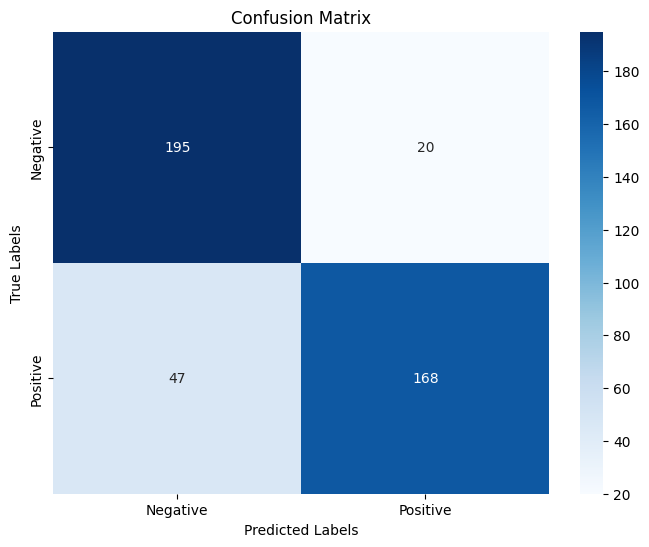

In [16]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.round(predictions).astype(int).flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Compute the classification report including F1-score
class_report = classification_report(y_true, y_pred, target_names=test_dataset.class_names)
print('\nClassification Report:\n', class_report)


Classification Report:
               precision    recall  f1-score   support

 NoAvalanche       0.81      0.91      0.85       215
YesAvalanche       0.89      0.78      0.83       215

    accuracy                           0.84       430
   macro avg       0.85      0.84      0.84       430
weighted avg       0.85      0.84      0.84       430



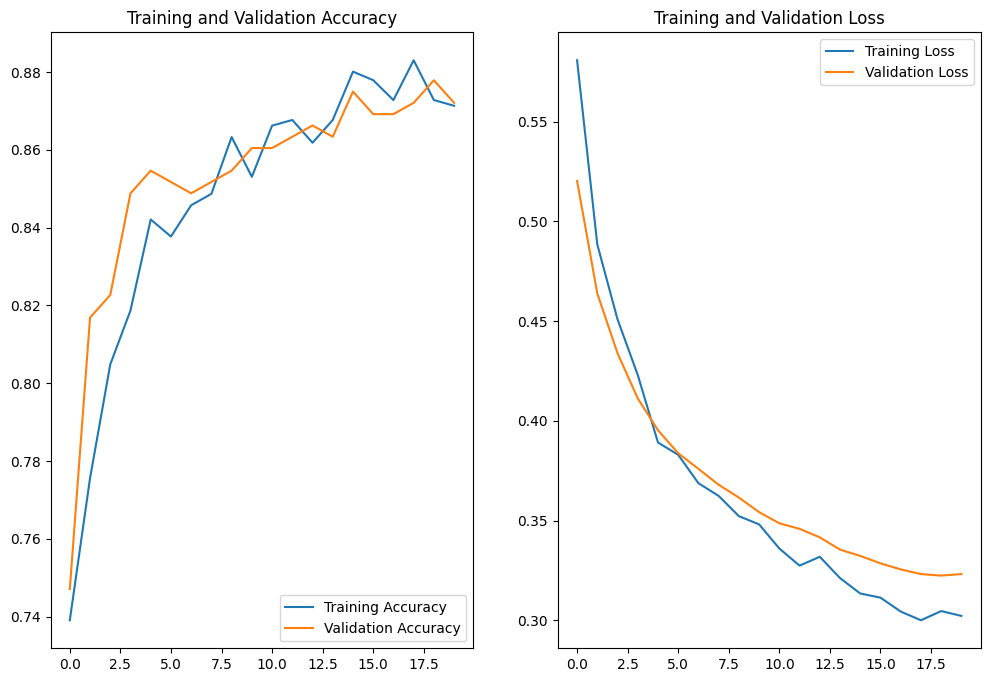

In [18]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Misclassified images

14/14 [==============================] - 5s 114ms/step


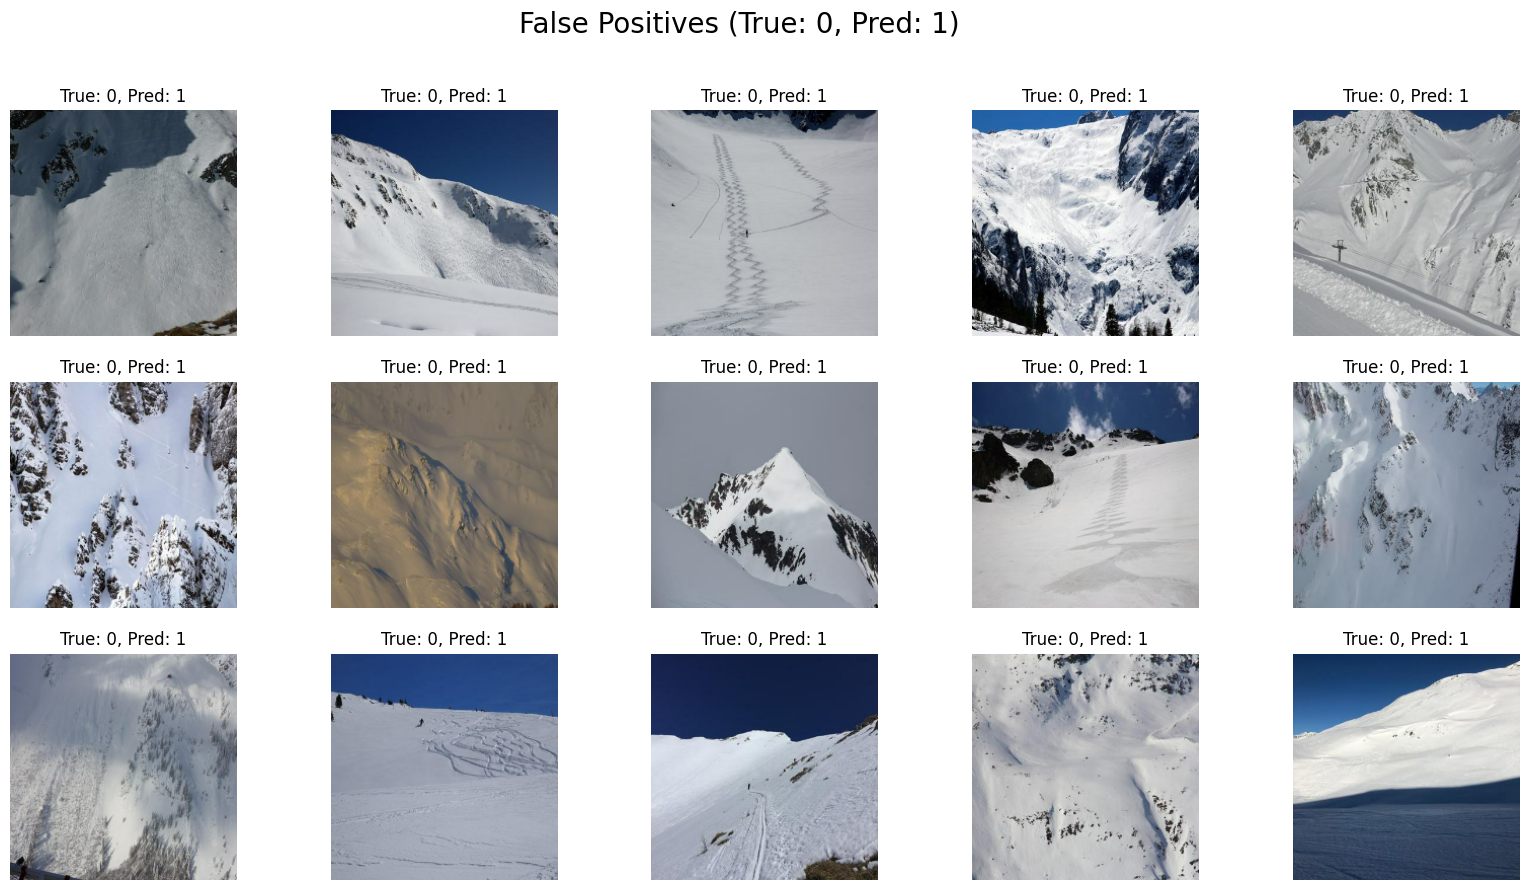

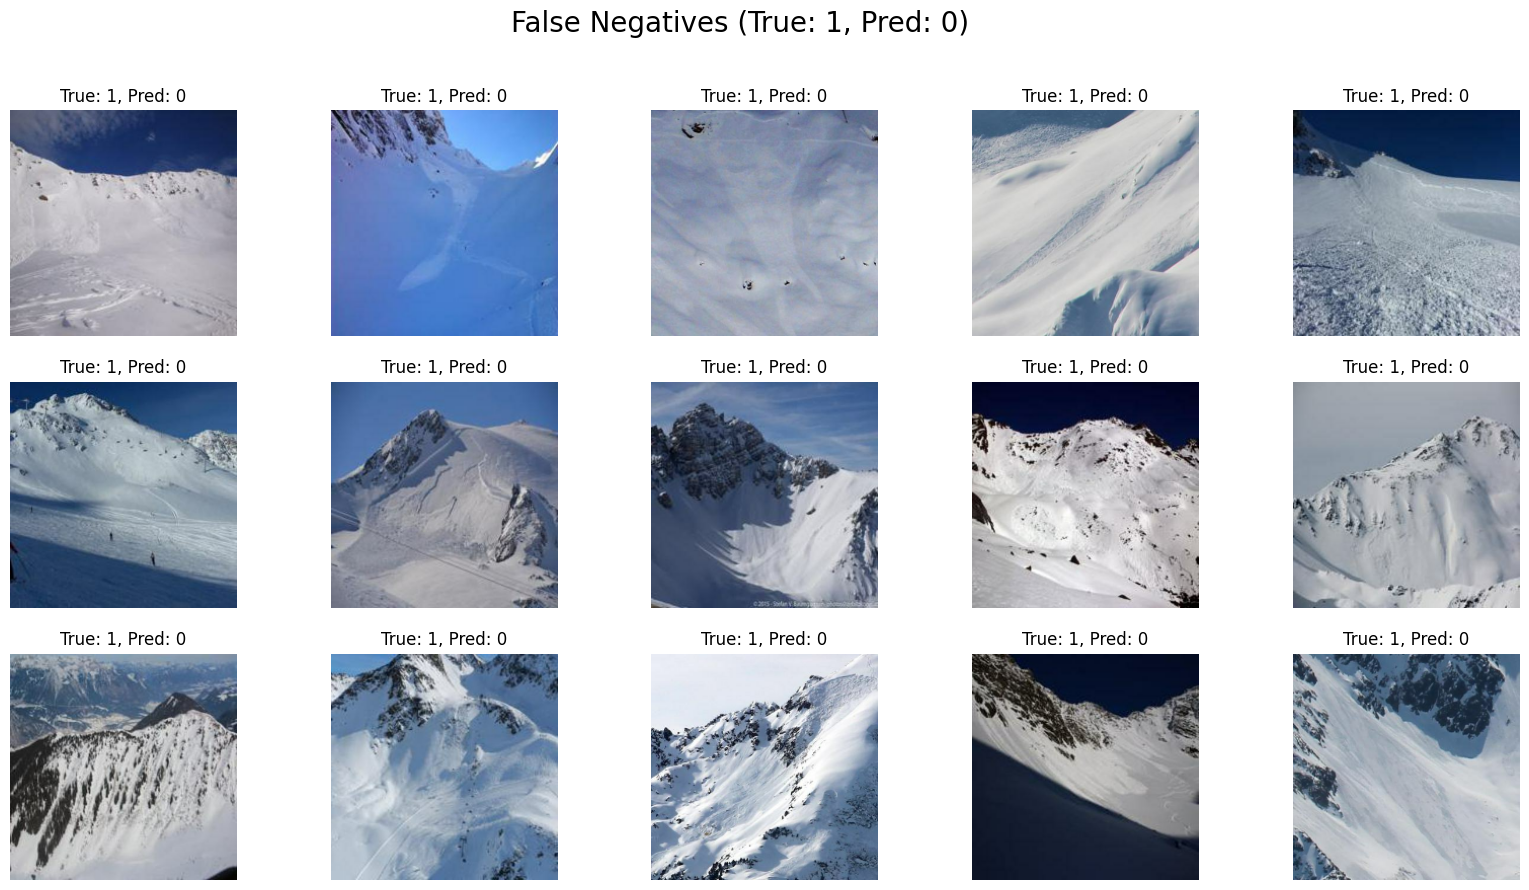

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate predictions for the test dataset
test_predictions = best_model.predict(test_dataset)
test_predictions = (test_predictions > 0.5).astype(int).flatten()  # For binary classification

# Extract true labels and images from the test dataset
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Identify misclassified instances
false_positives = np.where((test_predictions == 1) & (test_labels == 0))[0]
false_negatives = np.where((test_predictions == 0) & (test_labels == 1))[0]

# Function to plot misclassified images
def plot_misclassified_images(indices, title, num_examples=15):
    plt.figure(figsize=(20, 10))
    for i, index in enumerate(indices[:num_examples]):
        plt.subplot(3, 5, i + 1)
        plt.imshow(test_images[index].astype("uint8"))
        plt.title(f"True: {test_labels[index]}, Pred: {test_predictions[index]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

# Plot 15 false positives
plot_misclassified_images(false_positives, 'False Positives (True: 0, Pred: 1)', num_examples=15)

# Plot 15 false negatives
plot_misclassified_images(false_negatives, 'False Negatives (True: 1, Pred: 0)', num_examples=15)
